In [1]:
import numpy as np 
import pandas as pd 
import psycopg2
import sqlalchemy
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
%matplotlib inline

## Membuat Koneksi ke postgresql

In [2]:
# connect postgres ONLINE
from sqlalchemy import create_engine
#postgres username, password, and database name
POSTGRES_ADDRESS = 'db-postgresql-nyc1-45373-do-user-2306548-0.db.ondigitalocean.com'
POSTGRES_PORT = '25060'
POSTGRES_USERNAME = 'doadmin'
POSTGRES_DBNAME = 'iykra_online_store'
POSTGRES_PASSWORD = 'bjx5qln81af941jw'

postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'.format(
               username=POSTGRES_USERNAME,
               password=POSTGRES_PASSWORD,
               ipaddress=POSTGRES_ADDRESS,
               port=POSTGRES_PORT,
               dbname=POSTGRES_DBNAME))
#create connection
cnx_online = create_engine(postgres_str)

## Membuat customer profiling monetary

In [3]:
dfmonetary = pd.read_sql_query("""select customer_id,
count(distinct invoice_no) total_order,
sum(quantity*unit_price) total_spending,
sum(quantity*unit_price)/count(distinct(invoice_no)) basket_size
from transaction
where customer_id is not null and quantity > 0
group by customer_id""",cnx_online)
dfmonetary

,customer_id,total_order,total_spending,basket_size
0,12346,1,77183.60,77183.600000
1,12347,7,4310.00,615.714286
2,12348,4,1797.24,449.310000
3,12349,1,1757.55,1757.550000
4,12350,1,334.40,334.400000
5,12352,8,2506.04,313.255000
6,12353,1,89.00,89.000000
7,12354,1,1079.40,1079.400000
8,12355,1,459.40,459.400000
9,12356,3,2811.43,937.143333


## Soal 2. Membuat klasifikasi tinggi-rendah R F M

### Membuat masing-masing tabel klasifikasi

#### Recency

In [4]:
dfrecency = pd.read_sql_query("""with customer_trx as (
select customer_id, 
date(invoice_date) invoice_date,
count(distinct(invoice_no)) total_order,
count(distinct(date(invoice_date))) total_date,
sum(quantity*unit_price) as bucket_size
from transaction
where customer_id is not null
group by 1,2
order by 1,2)
, customer_day_diff as (
select customer_id, 
invoice_date, 
total_order, 
total_date,
date(invoice_date)-date(lag(invoice_date, 1) over (partition by customer_id order by invoice_date)) as day_diff
from customer_trx)
, customer_day_diff2 as (
select customer_id, sum(total_order) total_order, sum(total_date) total_day,
avg(day_diff) avg_recency, max(day_diff) max_recency, min(day_diff) min_recency
from customer_day_diff
where day_diff is not null
group by 1
order by 1)
select *, case
when avg_recency < (select percentile_cont(0.5) within group(order by avg_recency) from customer_day_diff2) then 'Low' else 'High'
end as Recency
from customer_day_diff2""",cnx_online)
dfrecency

,customer_id,total_order,total_day,avg_recency,max_recency,min_recency,recency
0,12347,6.0,6.0,60.833333,90,37,High
1,12348,3.0,3.0,94.333333,173,40,High
2,12352,10.0,6.0,43.333333,182,5,Low
3,12356,2.0,2.0,151.500000,223,80,High
4,12358,1.0,1.0,149.000000,149,149,High
5,12359,5.0,5.0,64.800000,132,26,High
6,12360,2.0,2.0,74.000000,88,60,High
7,12362,12.0,12.0,24.333333,70,2,Low
8,12363,1.0,1.0,133.000000,133,133,High
9,12364,3.0,3.0,35.000000,38,33,Low


In [5]:
print('jumlah recency high:',len(dfrecency[dfrecency['recency'] == 'High']))
print('jumlah recency low:',len(dfrecency[dfrecency['recency'] == 'Low']))

jumlah recency high: 1497
jumlah recency low: 1494


#### Frequency

In [6]:
dffrequency = pd.read_sql_query("""with customer_frequency as (
select customer_id,
extract(year from invoice_date) year_number,
extract(month from invoice_date) month_number,
count(distinct(invoice_no)) total_order
from transaction
where customer_id is not null 
group by 1,2,3
order by 1,2,3)
, customer_frequency2 as (select customer_id, 
avg(total_order) avg_total_order_monthly,
max(total_order) max_total_order, 
min(total_order) min_total_order,
count(customer_id) total_active_month, 
sum(total_order) total_all_order
from customer_frequency
group by 1)
select *,case
when total_all_order < (select percentile_cont(0.5) within group(order by total_all_order) from customer_frequency2) then 'Low' else 'High'
end as Frequency
from customer_frequency2
order by customer_id""",cnx_online)
dffrequency

,customer_id,avg_total_order_monthly,max_total_order,min_total_order,total_active_month,total_all_order,frequency
0,12346,2.000000,2,2,1,2.0,Low
1,12347,1.000000,1,1,7,7.0,High
2,12348,1.000000,1,1,4,4.0,High
3,12349,1.000000,1,1,1,1.0,Low
4,12350,1.000000,1,1,1,1.0,Low
5,12352,2.750000,7,1,4,11.0,High
6,12353,1.000000,1,1,1,1.0,Low
7,12354,1.000000,1,1,1,1.0,Low
8,12355,1.000000,1,1,1,1.0,Low
9,12356,1.000000,1,1,3,3.0,High


In [7]:
print('jumlah frequency high:',len(dffrequency[dffrequency['frequency'] == 'High']))
print('jumlah frequency low:',len(dffrequency[dffrequency['frequency'] == 'Low']))

jumlah frequency high: 2242
jumlah frequency low: 2130


#### Monetary

In [8]:
dfmonetary = pd.read_sql_query("""with monetize as (select customer_id,
count(distinct invoice_no) total_order,
sum(quantity*unit_price) total_spending,
sum(quantity*unit_price)/count(distinct(invoice_no)) basket_size
from transaction
where customer_id is not null and quantity > 0
group by customer_id)
select *,case 
when basket_size < (select percentile_cont(0.5) within group(order by basket_size) from monetize) then 'Low' else 'High'
end as monetary
from monetize""",cnx_online)
dfmonetary

,customer_id,total_order,total_spending,basket_size,monetary
0,12346,1,77183.60,77183.600000,High
1,12347,7,4310.00,615.714286,High
2,12348,4,1797.24,449.310000,High
3,12349,1,1757.55,1757.550000,High
4,12350,1,334.40,334.400000,High
5,12352,8,2506.04,313.255000,High
6,12353,1,89.00,89.000000,Low
7,12354,1,1079.40,1079.400000,High
8,12355,1,459.40,459.400000,High
9,12356,3,2811.43,937.143333,High


In [9]:
print('jumlah monetary high:',len(dfmonetary[dfmonetary['monetary'] == 'High']))
print('jumlah monetary low:',len(dfmonetary[dfmonetary['monetary'] == 'Low']))

jumlah monetary high: 2170
jumlah monetary low: 2169


### Menggabungkan seluruh tabel

In [10]:
dfjoin = pd.merge(pd.merge(dfrecency,dffrequency, on = 'customer_id'),dfmonetary, on = 'customer_id')
dfjoin

,customer_id,total_order_x,total_day,avg_recency,max_recency,min_recency,recency,avg_total_order_monthly,max_total_order,min_total_order,total_active_month,total_all_order,frequency,total_order_y,total_spending,basket_size,monetary
0,12347,6.0,6.0,60.833333,90,37,High,1.000000,1,1,7,7.0,High,7,4310.00,615.714286,High
1,12348,3.0,3.0,94.333333,173,40,High,1.000000,1,1,4,4.0,High,4,1797.24,449.310000,High
2,12352,10.0,6.0,43.333333,182,5,Low,2.750000,7,1,4,11.0,High,8,2506.04,313.255000,High
3,12356,2.0,2.0,151.500000,223,80,High,1.000000,1,1,3,3.0,High,3,2811.43,937.143333,High
4,12358,1.0,1.0,149.000000,149,149,High,1.000000,1,1,2,2.0,Low,2,1168.06,584.030000,High
5,12359,5.0,5.0,64.800000,132,26,High,1.000000,1,1,6,6.0,High,4,6372.58,1593.145000,High
6,12360,2.0,2.0,74.000000,88,60,High,1.000000,1,1,3,3.0,High,3,2662.06,887.353333,High
7,12362,12.0,12.0,24.333333,70,2,Low,1.625000,3,1,8,13.0,High,10,5226.23,522.623000,High
8,12363,1.0,1.0,133.000000,133,133,High,1.000000,1,1,2,2.0,Low,2,552.00,276.000000,Low
9,12364,3.0,3.0,35.000000,38,33,Low,1.000000,1,1,4,4.0,High,4,1313.10,328.275000,High


### Tabel Klasifikasi RFM

In [11]:
dfsoal2 = dfjoin[['customer_id','recency','frequency','monetary']]
dfsoal2

,customer_id,recency,frequency,monetary
0,12347,High,High,High
1,12348,High,High,High
2,12352,Low,High,High
3,12356,High,High,High
4,12358,High,Low,High
5,12359,High,High,High
6,12360,High,High,High
7,12362,Low,High,High
8,12363,High,Low,Low
9,12364,Low,High,High


## Soal 3. Mencari negara yang memiliki lowest recency dan highest monetary

### Inner join dengan tabel customer

In [12]:
dfcustomer = pd.read_sql_query("select * from customer",cnx_online)
dfmerge = pd.merge(dfsoal2,dfcustomer,how ='inner')
dfsoal3 = dfmerge[['country','recency','monetary']]
dfsoal3

,country,recency,monetary
0,Iceland,High,High
1,Finland,High,High
2,Norway,Low,High
3,Portugal,High,High
4,Austria,High,High
5,Cyprus,High,High
6,Austria,High,High
7,Belgium,Low,High
8,Unspecified,High,Low
9,Belgium,Low,High


### menghitung masing2 jumlah high-low pada recency dan monetary dan di group by negara

In [13]:
dfcount = pd.get_dummies(dfmerge[['recency','monetary']])
dfsoal3final = pd.concat([dfsoal3,dfcount], axis = 'columns')
dfsoal3final

,country,recency,monetary,recency_High,recency_Low,monetary_High,monetary_Low
0,Iceland,High,High,1,0,1,0
1,Finland,High,High,1,0,1,0
2,Norway,Low,High,0,1,1,0
3,Portugal,High,High,1,0,1,0
4,Austria,High,High,1,0,1,0
5,Cyprus,High,High,1,0,1,0
6,Austria,High,High,1,0,1,0
7,Belgium,Low,High,0,1,1,0
8,Unspecified,High,Low,1,0,0,1
9,Belgium,Low,High,0,1,1,0


In [14]:
dfsoal3final.groupby('country', as_index=False)[['recency_High','recency_Low','monetary_High','monetary_Low']].sum().sort_values('monetary_High', ascending= False)

,country,recency_High,recency_Low,monetary_High,monetary_Low
31,United Kingdom,1369.0,1329.0,1389.0,1309.0
12,Germany,22.0,52.0,50.0,24.0
11,France,26.0,36.0,43.0,19.0
26,Spain,14.0,6.0,16.0,4.0
2,Belgium,6.0,11.0,13.0,4.0
28,Switzerland,5.0,9.0,13.0,1.0
23,Portugal,6.0,9.0,10.0,5.0
7,Denmark,5.0,2.0,6.0,1.0
0,Australia,5.0,3.0,5.0,3.0
4,Channel Islands,5.0,1.0,5.0,1.0


# Jawaban No 3 adalah United Kingdom

## Membuat chart yang menjelaskan behaviour profile dalam membeli barang

In [15]:
dfsoal2.loc[(dfsoal2['recency'] == 'High') & (dfsoal2['frequency'] == 'High') & (dfsoal2['monetary'] == 'High'),'profiling'] = 'HHH'
dfsoal2.loc[(dfsoal2['recency'] == 'High') & (dfsoal2['frequency'] == 'High') & (dfsoal2['monetary'] == 'Low'),'profiling'] = 'HHL'
dfsoal2.loc[(dfsoal2['recency'] == 'High') & (dfsoal2['frequency'] == 'Low') & (dfsoal2['monetary'] == 'High'),'profiling'] = 'HLH'
dfsoal2.loc[(dfsoal2['recency'] == 'High') & (dfsoal2['frequency'] == 'Low') & (dfsoal2['monetary'] == 'Low'),'profiling'] = 'HLL' 
dfsoal2.loc[(dfsoal2['recency'] == 'Low') & (dfsoal2['frequency'] == 'High') & (dfsoal2['monetary'] == 'High'),'profiling'] = 'LHH'
dfsoal2.loc[(dfsoal2['recency'] == 'Low') & (dfsoal2['frequency'] == 'Low') & (dfsoal2['monetary'] == 'Low'),'profiling'] = 'LLL'
dfsoal2.loc[(dfsoal2['recency'] == 'Low') & (dfsoal2['frequency'] == 'Low') & (dfsoal2['monetary'] == 'High'),'profiling'] = 'LLH'
dfsoal2.loc[(dfsoal2['recency'] == 'Low') & (dfsoal2['frequency'] == 'High') & (dfsoal2['monetary'] == 'Low'),'profiling'] = 'LHL' 
dfprofiling = dfsoal2
dfprofiling

d:\new folder\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
d:\new folder\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,customer_id,recency,frequency,monetary,profiling
0,12347,High,High,High,HHH
1,12348,High,High,High,HHH
2,12352,Low,High,High,LHH
3,12356,High,High,High,HHH
4,12358,High,Low,High,HLH
5,12359,High,High,High,HHH
6,12360,High,High,High,HHH
7,12362,Low,High,High,LHH
8,12363,High,Low,Low,HLL
9,12364,Low,High,High,LHH


In [17]:
df_cm = pd.read_sql_query("""

select customer_id, extract(day from invoice_date) as tanggal_transaksi, count(distinct invoice_no) from transaction

group by tanggal_transaksi, customer_id order by tanggal_transaksi""", cnx_online)

df_cm.head()

,customer_id,tanggal_transaksi,count
0,12352.0,1.0,4
1,12373.0,1.0,1
2,12415.0,1.0,3
3,12423.0,1.0,1
4,12428.0,1.0,3


In [18]:
df_profile_tanggal = pd.merge(df_cm,dfprofiling,on='customer_id')
df_profile_tanggal2 = df_profile_tanggal[['profiling','tanggal_transaksi','count']]
df_profile_tanggal2

,profiling,tanggal_transaksi,count
0,LHH,1.0,4
1,LHH,3.0,1
2,LHH,16.0,1
3,LHH,17.0,1
4,LHH,20.0,1
5,LHH,22.0,2
6,LHH,28.0,1
7,LHH,1.0,3
8,LHH,2.0,2
9,LHH,3.0,3


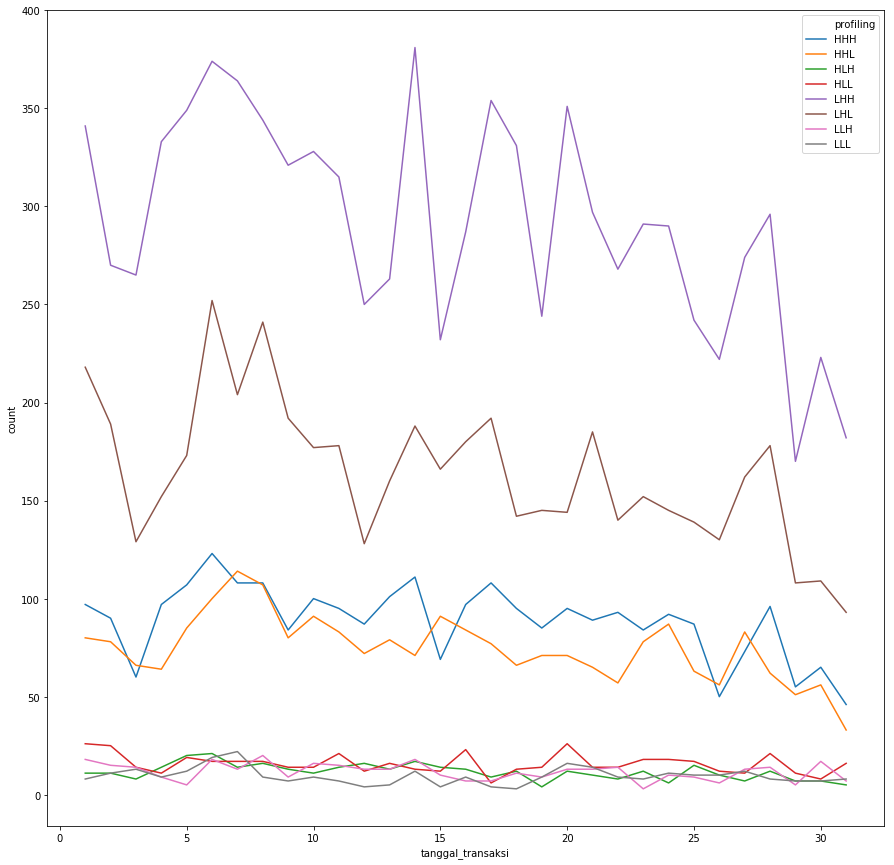

In [20]:
plt.figure(figsize=(15,15))
sns.lineplot(x="tanggal_transaksi", y="count", hue="profiling", data=df_profile_tanggal3)
plt.show()

## Nama Barang Terbanyak yang Dibeli Setiap Profile

In [32]:
dfproduct = pd.read_sql_query("""
select transaction.customer_id, product.description, sum(transaction.quantity) as jumlah from transaction
join product on transaction.stock_code = product.stock_code
where customer_id is not null
group by customer_id,product.description""", cnx_online)

dfproduct

,customer_id,description,jumlah
0,12346,MEDIUM CERAMIC TOP STORAGE JAR,0
1,12347,3D DOG PICTURE PLAYING CARDS,126
2,12347,3D SHEET OF CAT STICKERS,12
3,12347,3D SHEET OF DOG STICKERS,12
4,12347,60 TEATIME FAIRY CAKE CASES,72
5,12347,72 SWEETHEART FAIRY CAKE CASES,72
6,12347,AIRLINE BAG VINTAGE JET SET BROWN,28
7,12347,AIRLINE BAG VINTAGE JET SET RED,16
8,12347,AIRLINE BAG VINTAGE JET SET WHITE,12
9,12347,AIRLINE BAG VINTAGE TOKYO 78,32


In [33]:
dfprofileproduct = pd.merge(dfproduct,dfprofiling,on='customer_id')
df_profile_product2 = dfprofileproduct[['profiling','description','jumlah']]
df_profile_product2

,profiling,description,jumlah
0,HHH,3D DOG PICTURE PLAYING CARDS,126
1,HHH,3D SHEET OF CAT STICKERS,12
2,HHH,3D SHEET OF DOG STICKERS,12
3,HHH,60 TEATIME FAIRY CAKE CASES,72
4,HHH,72 SWEETHEART FAIRY CAKE CASES,72
5,HHH,AIRLINE BAG VINTAGE JET SET BROWN,28
6,HHH,AIRLINE BAG VINTAGE JET SET RED,16
7,HHH,AIRLINE BAG VINTAGE JET SET WHITE,12
8,HHH,AIRLINE BAG VINTAGE TOKYO 78,32
9,HHH,AIRLINE BAG VINTAGE WORLD CHAMPION,8


In [34]:
df_profile_product3 = df_profile_product2.groupby(['profiling','description'],as_index=False)['jumlah'].sum()
df_profile_product3

,profiling,description,jumlah
0,HHH,4 PURPLE FLOCK DINNER CANDLES,13
1,HHH,50'S CHRISTMAS GIFT BAG LARGE,342
2,HHH,DOLLY GIRL BEAKER,200
3,HHH,I LOVE LONDON MINI BACKPACK,22
4,HHH,NINE DRAWER OFFICE TIDY,8
5,HHH,OVAL WALL MIRROR DIAMANTE,20
6,HHH,RED SPOT GIFT BAG LARGE,400
7,HHH,SET 2 TEA TOWELS I LOVE LONDON,946
8,HHH,SPACEBOY BABY GIFT SET,68
9,HHH,TOADSTOOL BEDSIDE LIGHT,42


# Best Item in Every Profile

In [35]:
df_profile_product3.sort_values('jumlah', ascending=False).drop_duplicates('profiling').sort_values('jumlah',ascending=False)

,profiling,description,jumlah
12779,LHH,POPCORN HOLDER,34147
2585,HHH,SMALL CHINESE STYLE SCISSOR,12750
3999,HHL,ESSENTIAL BALM 3.5g TIN IN ENVELOPE,5675
16030,LHL,POPCORN HOLDER,3517
8460,HLL,ASSORTED LAQUERED INCENSE HOLDERS,2019
6379,HLH,BROCADE RING PURSE,1656
18939,LLH,VINTAGE DOILY JUMBO BAG RED,1523
19152,LLL,ASSORTED COLOUR BIRD ORNAMENT,405


## 3 best item tiap profile

In [36]:
df_profile_product3.sort_values('jumlah',ascending=False).groupby('profiling').head(3).sort_values(['profiling','jumlah'],ascending=[True,False])

,profiling,description,jumlah
2585,HHH,SMALL CHINESE STYLE SCISSOR,12750
1810,HHH,PACK OF 72 RETROSPOT CAKE CASES,8535
3006,HHH,WORLD WAR 2 GLIDERS ASSTD DESIGNS,7248
3999,HHL,ESSENTIAL BALM 3.5g TIN IN ENVELOPE,5675
3497,HHL,BROCADE RING PURSE,2565
3766,HHL,CREAM HANGING HEART T-LIGHT HOLDER,2182
6379,HLH,BROCADE RING PURSE,1656
6203,HLH,ASSORTED COLOUR BIRD ORNAMENT,945
6207,HLH,ASSORTED COLOURS SILK FAN,876
8460,HLL,ASSORTED LAQUERED INCENSE HOLDERS,2019
